# One-dimensional advection

In this notebook, I explain the different sections of the M-file script `advection_1d.m` and the M-file function `run_model.m` that simulate the advection of a tracer anomaly by a narrow current. The complete code of both M-files is given in a separate notebook [advection_1d_upwind](advection_1d_upwind.ipynb). For a detailed description of the exercise, see the PDF document [e04_advection_1d_exercise.pdf](https://seafile.zfn.uni-bremen.de/f/a2e551f474c14e26bdf8/).

## M-file script `advection_1d.m`

First, I go through the M-file script or "main program" `advection_1d.m`. As in the solar heating and zero-dimensional energy balance models, the first section of the M-file script `advection_1d.m` serves to set constants and parameters:

In [1]:
% Set named constants
SECONDS_PER_DAY = 86400.0; % seconds per day
M2KM            = 1.0E-03; % m to km conversion factor

In this case, this includes setting the number of spatial grid points `Ny`, the origin of the spatial grid `ygOrigin` and the width `deltaX` in the x-direction, height `deltaY` in the y-direction and depth `deltaR` in the z-direction of the grid cells:

In [2]:
% Set array size(s)
Ny = 400; % no. points in Y for the total domain

% Set up horizontal grid and coordinate system
ygOrigin =   0.0;
deltaX   = 100.0E03; % width/m
deltaY   =  10.0E03; % height/m
deltaR   = 100.0;    % depth/m

Thus there are 400 grid points in total. Each grid cell is 100 km wide, 10 km high and 100 m deep, in accordance with the specifications given in the exercise. The total extent of the grid is 400 times 10 km, or 4000 km. 

Next the locations of the  grid-cell faces `yG` are defined in a `for`-loop. The variable `yG` is defined as a one-dimensional array or vector. Initially, all 401 elements are set to zero. Then the origin of the grid `ygOrigin` is assigned to the first element `yG(1)`. Subsequently, all other elements are set in `for`-loop, by setting `yG(2)`to `yG(1) + deltaY` and so on:

In [3]:
% Calculate latitudes of N+1 grid-lines/cell faces
yG    = zeros(Ny + 1, 1);
yG(1) = ygOrigin;
for j=1:Ny
    yG(j + 1) = yG(j) + deltaY;
end

As a result, the locations of the first 10 grid-cell faces `yG` in units of m are:

In [4]:
yG(1:10)

ans =

       0
   10000
   20000
   30000
   40000
   50000
   60000
   70000
   80000
   90000



Similarly, the locations of the grid-cell centers can be defined in a `for`-loop, too. They are calculated from the average of the locations of the grid-cell faces to the left and to the right, for example, `yC(1)` is set to `0.5*(yG(1) + yG(2))`:

In [5]:
% Calculate latitudes of cell centers by averaging
yC    = zeros(Ny, 1);
for j=1:Ny
    yC(j)     = 0.5*(yG(j) + yG(j + 1));
end

Hence the locations of the first 10 grid-cell centers `yC` in units of m are:

In [6]:
yC(1:10)

ans =

    5000
   15000
   25000
   35000
   45000
   55000
   65000
   75000
   85000
   95000



Now the grid-cell face areas `yA` (in units of m<sup>2</sup>) and volumes (in units of m<sup>3</sup>), as well as the advection velocity `uVel` (in units of m s<sup>-1</sup>) are set:

In [7]:
% Calculate face areas normal to X direction
yA = zeros(Ny+1, 1);
for j=1:Ny+1
    yA(j) = deltaX*deltaR;
end

% Calculate grid-cell volumes
volume = zeros(Ny, 1);
for j=1:Ny
    volume(j) = deltaR*deltaX*deltaY;
end

% Set other fields
vVel = zeros(Ny + 1, 1); % velocity for advection (m s-1)                                          
for j=1:Ny+1
    vVel(j) = 2.0;
end

Although these variables are one-dimensional arrays or vectors, their values are constant. For example, the first 10 values of the advection velocity `vVel` in units of m s<sup>-1</sup> are:

In [8]:
vVel(1:10)

ans =

   2
   2
   2
   2
   2
   2
   2
   2
   2
   2



After defining the grid, the run parameters are set:

In [9]:
% Set run parameters
deltaT     = 1200.0; % time step/s
startTime  =    0.0; % time to start integration/d
endTime    =   20.0; % time to stop integration/d

% Set total number of time steps
nTimeSteps = round((endTime - startTime)*SECONDS_PER_DAY/deltaT);

With the time step `deltaT` set to 1200 s and the duration of the simulation `endTime - startTime` set to 20 days, the total number of time steps `nTimeSteps` to be taken becomes:

In [10]:
nTimeSteps

nTimeSteps =  1440


The advection equation is a partial differential equation (PDE) of first order in time. In order to solve it, we need to specify the initial tracer anomaly, which is also defined as one-dimensional array or vector `initialTracer`:

In [11]:
% Set initial conditions
initialTracer = zeros(Ny  , 1); % tracer
for j=1:Ny
    if yC(j) > 370.0E03 && yC(j) < 630.0E03
        initialTracer(j) = 1.0;
    end    
end

The initial tracer anomaly is set to zero everywhere except in the interval between 370 km and 630 km downstream, as can be seen in the following plot:

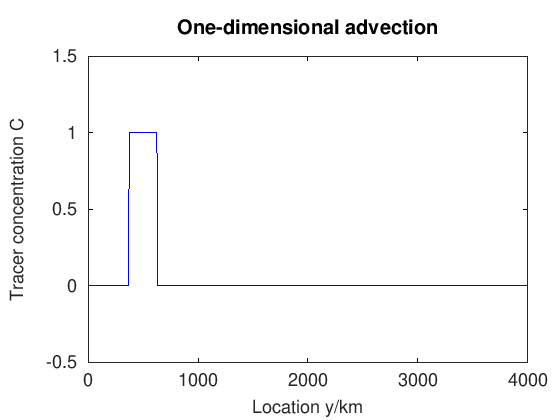

In [12]:
%plot inline

% Plot initial concentration profile
plot(yC/1.0E03, initialTracer, 'Color', 'b', 'LineWidth', 2)

% Refine plot
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)

Before calling the M-file function that solves the advection equation numerically, we define the structure arrays `Constants`, `Sizes`, `Grids`, `RunParameters` and `ModelParameters`. While `RunParameters` specifies the discretization in time, `Sizes` and `Grids` specify the discretization in space:

In [13]:
% Store parameters and variable(s) in structure arrays
Constants.SECONDS_PER_DAY     = SECONDS_PER_DAY;
Constants.M2KM                = M2KM; 
Sizes.Ny                      = Ny;
Grids.yC                      = yC;
Grids.yA                      = yA;   
Grids.volume                  = volume;
RunParameters.deltaT          = deltaT;
RunParameters.startTime       = startTime;
RunParameters.nTimeSteps      = nTimeSteps;
ModelParameters.vVel          = vVel;
ModelParameters.initialTracer = initialTracer;

In our application, `Sizes` contains a single field, which is the number of grid points in the y-direction `Ny`:

In [14]:
Sizes

Sizes =

  scalar structure containing the fields:

    Ny =  400



In principle, now that all variables are defined and initialized, we can call the M-file function or "subprogram" that carries out the numerical integration using the forward-in-time method and upwind scheme.

However, we first need to define the M-file function. In a Jupyter noetebook, we also need to execute it once in order to save it to an internal M-file. First I provide the necessary code in the following cell and comment on it afterwards:

In [15]:
%%file run_model_upwind.m

function run_model_upwind(Constants, Sizes, Grids, ... 
                          RunParameters, ModelParameters)
% RUN_MODEL_UPWIND Direct integration of advection using the upwind scheme.

% Retrieve parameters and variable(s) from structure arrays
SECONDS_PER_DAY = Constants.SECONDS_PER_DAY;
M2KM            = Constants.M2KM;
Ny              = Sizes.Ny;
yC              = Grids.yC;   
yA              = Grids.yA;
volume          = Grids.volume;
deltaT          = RunParameters.deltaT;
startTime       = RunParameters.startTime;
nTimeSteps      = RunParameters.nTimeSteps;
vVel            = ModelParameters.vVel;
initialTracer   = ModelParameters.initialTracer;

% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
tracerNm1 = tracer;     % tracer at time level n - 1

% Initialize plot (tracer concentration)
p1 = plot(yC*M2KM, tracer, 'r');
set(p1,'linewidth', 2);
grid on
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)

% Preallocate arrays for speed
afy     = zeros(Ny + 1, 1); % advective flux in Y direction
vTrans  = zeros(Ny + 1, 1); % meridional volume transport through cell
gTracer = zeros(Ny    , 1); % tendency due to advection

% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
    
    % Record simulated time
    myTime = myTime + deltaT;

    % Calculate common factors (e.g., volume fluxes) on right-hand side
    for j=1:Ny
        vTrans(j) = vVel(j)*yA(j);
    end

    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "upwind" scheme
        if vTrans(j) > 0.0
            afy(j) = vTrans(j)*tracer(j - 1);
        else
            afy(j) = vTrans(j)*tracer(j);
        end
    end

    % Calculate surface tracer tendency due to internal processes
    % (here advection only)
    for j=1:Ny
        % Divergence of fluxes
        gTracer(j) = (afy(j) - afy(j + 1))/volume(j);
    end

    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" (FT) method)
    tracer = tracer + deltaT*gTracer;
   
    % Plot values as calculation proceeds
    set(p1, 'XData', yC*M2KM, 'YData', tracer)
    drawnow

end % end of time loop

Created file '/Users/andre/Development/advection-1d/run_model_upwind.m'.


Finally, we can indeed call the M-file function `run_model_upwind.m`. Note that it contains code that animates the numerical solution if run in GNU Octave. In this Jupyter notebook, after execution only the result for the last time step is shown in an inline plot. The following two lines would actually be placed at the end of the calling M-file script `advection_1d.m`:

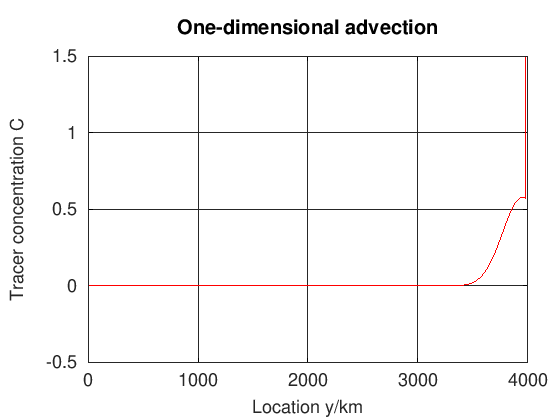

In [16]:
% Run model
run_model_upwind(Constants, Sizes, Grids, RunParameters, ModelParameters);

## Explaining the M-file function `run_model_upwind.m`

Now I comment on the code of the M-file function `run_model_upwind.m` in detail:

The first line is continued to the second and defines the name of the function `run_model_upwind` as well as five input arguments:

```OCTAVE
function run_model_upwind(Constants, Sizes, Grids, ... 
                          RunParameters, ModelParameters)
```

The input arguments are the five structure arrays (structures for short) `Constants`, `Sizes`, `Grids`, `RunParameters` and `ModelParameters`. For convenience and to reduce writing, the input parameters and variables can be retrieved by accessing the fields of the structures using the `.` notation, for example, the number of grid points `Ny`can be retrieved from the `Sizes` structure as follow: `Ny = Sizes.Ny;`.

```OCTAVE
% Retrieve parameters and variable(s) from structure arrays
SECONDS_PER_DAY = Constants.SECONDS_PER_DAY;
M2KM            = Constants.M2KM;
Ny              = Sizes.Ny;
yC              = Grids.yC;   
yA              = Grids.yA;
volume          = Grids.volume;
deltaT          = RunParameters.deltaT;
startTime       = RunParameters.startTime;
nTimeSteps      = RunParameters.nTimeSteps;
vVel            = ModelParameters.vVel;
initialTracer   = ModelParameters.initialTracer;

```

Next the initial conditions are set: the initial time and the initial tracer distribution.

```OCTAVE
% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
```

Then the initial tracer distribution is plotted as a function of the distance y in units of km. The plot is assigned to a variable `p1` such that it can be updated later:

```OCTAVE
% Initialize plot (tracer concentration)
p1 = plot(yC*M2KM, tracer, 'r');
set(p1,'linewidth', 2);
grid on
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)
```

To speed up the time stepping of the numerical solution, auxiliary variables are "pre-allocated", that is, they are defined as arrays of size `Ny + 1` (for the advective flux and volume transport at the grid-cell interfaces) and `Ny` (for the tendency due to advection at the grid-cell centers) and intialized to zero. Otherwise the size of these arrays would grow by one during each iteration of the time loop. This would require the allocation of additional memory in the computer during each iteration, which could slow down the program execution and cause a substantial increase in computing time. 

```OCTAVE
% Preallocate arrays for speed
afy     = zeros(Ny + 1, 1); % advective flux in Y direction
vTrans  = zeros(Ny + 1, 1); % meridional volume transport through cell
gTracer = zeros(Ny    , 1); % tendency due to advection
```

Now follows the time loop, that is, a `for` loop that is repated `nTimeSteps` times: 

```Octave
% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
```

The time loop in turn contains `for` loops that run over the spatial dimension. The following `for` loop calculates the volume transport `vTrans` from the product of the advection velocity `vVel` and the cross-sectional area `yA` for each grid cell: 

```OCTAVE
    % Calculate common factors (e.g., volume fluxes) on right-hand side
    for j=1:Ny
        vTrans(j) = vVel(j)*yA(j);
    end
```

Given the volume transport `vTrans`, the advective flux `afy` can now be calculated according to the upwind scheme. Depending on the sign (direction) of the volume transport, it is equal to the volume transport `vTrans(j)` times the tracer concentration to the left (south) `tracer(j - 1)` or the tracer concentration to the right (north) `tracer(j)`:

```OCTAVE
    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "upwind" scheme
        if vTrans(j) > 0.0
            afy(j) = vTrans(j)*tracer(j - 1);
        else
            afy(j) = vTrans(j)*tracer(j);
        end
    end
```

The tracer tendency is then equal to the divergence of the advective flux, that is, the difference between the advective flux to the right (north) `afy(j)` minus the advective flux from the left (south) `afy(j + 1)` divided by the volume of the grid cell `volume(j)`:

```OCTAVE
    % Calculate surface tracer tendency due to internal processes
    % (here advection only)
    for j=1:Ny
        % Divergence of fluxes
        gTracer(j) = (afy(j) - afy(j + 1))/volume(j);
    end
```

Eventually, the tracer concentration at the future time level (n + 1) can be calculated from the tracer concentration at the present time level (n) plus the time step times the tracer tendency:

```OCTAVE
    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" (FT) method)
    tracer = tracer + deltaT*gTracer;
```

This completes one iteration of the time loop and the plot `p1` can be updated with the new tracer distribution to generate the animation of the numerical solution:

```OCTAVE  
    % Plot values as calculation proceeds
    set(p1, 'XData', yC*M2KM, 'YData', tracer)
    drawnow
```

The execution of the M-file function stops right after the end of the time loop and the control is returned to the calling M-file script. In this case there are no output arguments, all output is to the screen.

```OCTAVE
end % end of time loop
```

## Modifying the M-file function `run_model_upwind.m`

The task is to modify the code of the M-file function `run_model_upwind.m` such that we can determine the time it takes for the tracer to reach the location $y$ = 3500 km downstream, using a threshold value for detecting the arrival of the tracer front  (for example, $C_{\rm crit} = 0.01$).

This can be accomplished by placing the following `if` statement after updating the plot `p1` with the new tracer distribution and before completing the time loop (in GNU Octave, you can copy and paste the statement in the M-file function run_model_upwind.m at the location of the question marks "???"):

```OCTAVE
    % Check for arrival of tracer front
    if tracer(350) > 0.01
        fprintf('Time = %6.3f d\n', myTime/SECONDS_PER_DAY)
        error('Arrival of temperature front');
    end
```

I selected the element at position 350 of the `tracer` array because it corresponds to the location of the grid-cell center `yC(350)`, which is at 3495 km downstream:

In [17]:
yC(350)

ans =  3495000


When the concentration in this grid cell exceeds the threshold value of 0.01, then the elapsed model time `myTime` is converted to days and printed to the screen using a fixed-point format `6.3f` with width 6 and 3 places after the decimal point. Finally, the built-in `error` function is called, which prints a message to the screen and stops the execution of the program.

The code of the M-file function `run_model_upwind.m` becomes:

In [18]:
%%file run_model_upwind.m

function run_model_upwind(Constants, Sizes, Grids, ... 
                          RunParameters, ModelParameters)
% RUN_MODEL_UPWIND Direct integration of advection using the upwind scheme.

% Retrieve parameters and variable(s) from structure arrays
SECONDS_PER_DAY = Constants.SECONDS_PER_DAY;
M2KM            = Constants.M2KM;
Ny              = Sizes.Ny;
yC              = Grids.yC;   
yA              = Grids.yA;
volume          = Grids.volume;
deltaT          = RunParameters.deltaT;
startTime       = RunParameters.startTime;
nTimeSteps      = RunParameters.nTimeSteps;
vVel            = ModelParameters.vVel;
initialTracer   = ModelParameters.initialTracer;

% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
tracerNm1 = tracer;     % tracer at time level n - 1

% Initialize plot (tracer concentration)
p1 = plot(yC*M2KM, tracer, 'r');
set(p1,'linewidth', 2);
grid on
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)

% Preallocate arrays for speed
afy     = zeros(Ny + 1, 1); % advective flux in Y direction
vTrans  = zeros(Ny + 1, 1); % meridional volume transport through cell
gTracer = zeros(Ny    , 1); % tendency due to advection

% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
    
    % Record simulated time
    myTime = myTime + deltaT;

    % Calculate common factors (e.g., volume fluxes) on right-hand side
    for j=1:Ny
        vTrans(j) = vVel(j)*yA(j);
    end

    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "upwind" scheme
        if vTrans(j) > 0.0
            afy(j) = vTrans(j)*tracer(j - 1);
        else
            afy(j) = vTrans(j)*tracer(j);
        end
    end

    % Calculate surface tracer tendency due to internal processes
    % (here advection only)
    for j=1:Ny
        % Divergence of fluxes
        gTracer(j) = (afy(j) - afy(j + 1))/volume(j);
    end

    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" (FT) method)
    tracer = tracer + deltaT*gTracer;
   
    % Plot values as calculation proceeds
    set(p1, 'XData', yC*M2KM, 'YData', tracer)
    drawnow
    
    % Check for arrival of tracer front
    if tracer(350) > 0.01
        fprintf('Time = %6.3f d\n', myTime/SECONDS_PER_DAY)
        error('Arrival of temperature front');
    end

end % end of time loop

Created file '/Users/andre/Development/advection-1d/run_model_upwind.m'.


We can call the modified function:

Time = 14.694 d
error: Arrival of temperature front
error: called from
    run_model_upwind at line 78 column 9


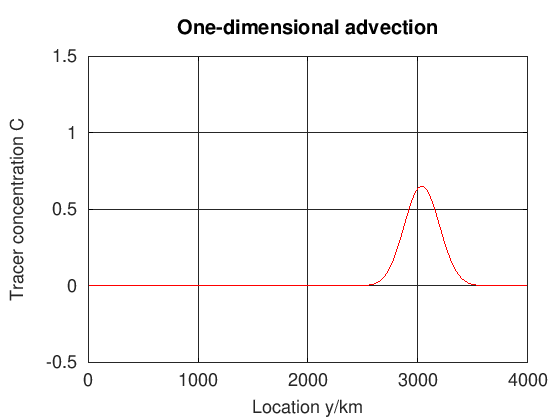

In [19]:
% Run model
run_model_upwind(Constants, Sizes, Grids, RunParameters, ModelParameters);

As a result, the front of the tracer anomaly reaches the location $y$ = 3500 km downstream after about 14.7 days.

## Completing the M-file function `run_model_ftcs.m`

The task for the M-file function `run_model_ftcs.m` is to implement the FTCS ("forward-in-time, centered-in-space") solution to the one-dimensional advection. First the same `if` statement that checks for the arrival of the tracer front needs to be inserted. Then the calculation of the advective fluxes needs to be completed, as indicated by the. question marks "???":

```OCTAVE
    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "centered-in-space" (CS) scheme
        afy(j) = ???;
    end
```

The formula for the "centered-in-space" (CS) scheme is given in the exercise as:

$$F_{\textrm{adv},j}^{(n)}=u_{j}\,\Delta A_{j}^{y}\,\frac{C_{j}^{(n)}+C_{j-1}^{(n)}}{2}\;.$$

Because $u_{j}\,\Delta A_{j}^{y}$ is equal to the volume transport `vTrans(j)`, this translates to the following MATLAB/Octave code:

```OCTAVE
    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "centered-in-space" (CS) scheme
        afy(j) = vTrans(j)*(tracer(j) + tracer(j - 1))/2.0;
    end
```

The complete code of the M-file function `run_model_ftcs.m` is:

In [20]:
%%file run_model_ftcs.m

function run_model_ftcs(Constants, Sizes, Grids, ... 
                        RunParameters, ModelParameters)
% RUN_MODEL_FTCS Direct integration of advection using the FTCS scheme.
% RUN_MODEL_FTCS directs the integration of the partial differential equation
% of one-dimensional advection using the "forward in time-centered in space"
% (FTCS) scheme.

% Author:           Andre Paul
% Written:          2011-11-30
% Last updated:     2019-11-14

% Check if the environment is Octave
is_octave = (exist ('OCTAVE_VERSION', 'builtin') > 0);

% Retrieve parameters and variable(s) from structure arrays
SECONDS_PER_DAY = Constants.SECONDS_PER_DAY;
M2KM            = Constants.M2KM;
Ny              = Sizes.Ny;
yC              = Grids.yC;   
yA              = Grids.yA;
volume          = Grids.volume;
deltaT          = RunParameters.deltaT;
startTime       = RunParameters.startTime;
nTimeSteps      = RunParameters.nTimeSteps;
vVel            = ModelParameters.vVel;
initialTracer   = ModelParameters.initialTracer;

% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
tracerNm1 = tracer;     % tracer at time level n - 1

% Initialize plot (tracer concentration)
if is_octave
    % -- code to run in Octave here --
    p1 = plot(yC*M2KM, tracer, 'r');
    set(p1,'linewidth', 2);
else
    % -- code to run in MATLAB R2014b and later here --   
    h = animatedline(yC*M2KM, tracer, 'Color', 'r', 'LineWidth', 2);
end
grid on
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)

% Preallocate arrays for speed
afy     = zeros(Ny + 1, 1); % advective flux in Y direction
vTrans  = zeros(Ny + 1, 1); % meridional volume transport through cell
gTracer = zeros(Ny    , 1); % tendency due to advection

% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
    
    % Record simulated time
    myTime = myTime + deltaT;

    % Calculate common factors (e.g., volume fluxes) on right-hand side
    for j=1:Ny
        vTrans(j) = vVel(j)*yA(j);
    end

    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "centered-in-space" (CS) scheme
        afy(j) = vTrans(j)*(tracer(j) + tracer(j - 1))/2.0;
    end

    % Calculate surface tracer tendency due to internal processes
    % (here advection only)
    for j=1:Ny
        % Divergence of fluxes
        gTracer(j) = (afy(j) - afy(j + 1))/volume(j);
    end

    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" (FT) method)
    tracer = tracer + deltaT*gTracer;
   
    % Plot values as calculation proceeds
    if is_octave
        % -- code to run in Octave here --
        set(p1, 'XData', yC*M2KM, 'YData', tracer)
    else
        % -- code to run in MATLAB R2014b and later here --   
        clearpoints(h)
        addpoints(h, yC*M2KM, tracer);
    end
    drawnow
   
    % Check for arrival of tracer front
    if tracer(350) > 0.01
        fprintf('Time = %6.3f d\n', myTime/SECONDS_PER_DAY)
        error('Arrival of temperature front');
    end

end % end of time loop

Created file '/Users/andre/Development/advection-1d/run_model_ftcs.m'.


It can be called with the same input arguments as the M-file function `run_model_upwind`:

Time = 16.625 d
error: Arrival of temperature front
error: called from
    run_model_ftcs at line 97 column 9


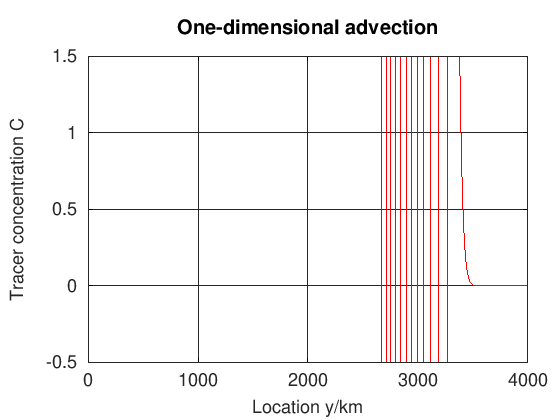

In [22]:
% Run model
run_model_ftcs(Constants, Sizes, Grids, RunParameters, ModelParameters);

What do you observe? You can answer this question more easily when you copy and paste the code to an M-file with the correct name and call the M-file function `run_model_ftcs` from the M-file script `advect_1d.m` in GNU Octave or MATLAB and watch the animation (for the M-file script, see [advection_1d_upwind](advection_1d_upwind.ipynb)).

## Completing the M-file function `run_model_leapfrog.m`

To begin with, the M-file function `run_model_leapfrog.m` is also incomplete. Again, the `if` statement that checks for the arrival of the tracer front needs to be inserted, as well as the calculation of the advective fluxes according to the formula for the "centered-in-space" (CS) scheme (see the previous section). Now in addition the time differencing needs to be changed to the “centered-in-time” (CT) method. This involves introducing two  additional variables `tracerNm1` and `tracerTmp`. The first one serves to save the tracer distribution at the past time level (n - 1) until the next iteration. It is initialized with the initial tracer distribution:

```OCTAVE
% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
tracerNm1 = tracer;     % tracer at time level n - 1
```

The second one is merely used to prevent overwriting the tracer distribution at the present time level (n), that is, `tracer`, before copying it to `tracerTmp`, as can be seen from the following code segment in the time loop (see also the explanation on p. 3 of the document [e04_advection_1d_exercise.pdf](https://seafile.zfn.uni-bremen.de/f/a2e551f474c14e26bdf8/)):

```OCTAVE
    % Step surface tracer forward in time 
    % (by "centered-in-time" (CT) method)
    tracerTmp = ???
    tracerNm1 = tracer;
    tracer    = tracerTmp;
```

At the location of the question marks "???" we need to insert the formula for the “centered-in-time” (CT) method, which according to the exercise is given by:

$$C_{j}^{(n+1)}=C_{j}^{(n-1)}+2\Delta t\,G_{\textrm{adv},j}^{(n)}\;.$$

In the MATLAB/Octave code segment, the right-hand side is temporaily stored in `tracerTmp`, hence:

```OCTAVE
    % Step surface tracer forward in time
    % (by "centered -in-time" (CT) method)
    tracerTmp = tracerNm1 + 2.0*deltaT*gTracer;
    tracerNm1 = tracer;
    tracer = tracerTmp;
```

The complete code of the M-file function `run_model_leapfrog.m` is:

In [24]:
%%file run_model_leapfrog.m

function run_model_leapfrog(Constants, Sizes, Grids, ... 
                            RunParameters, ModelParameters)
% RUN_MODEL_LEAPFROG Direct integration of advection using the leap-frog scheme.
% RUN_MODEL_LEAPFROG directs the integration of the partial differential
% equation of one-dimensional advection using the "leap-frog" scheme.

% Author:           Andre Paul
% Written:          2011-11-30
% Last updated:     2019-11-14

% Check if the environment is Octave
is_octave = (exist ('OCTAVE_VERSION', 'builtin') > 0);

% Retrieve parameters and variable(s) from structure arrays
SECONDS_PER_DAY = Constants.SECONDS_PER_DAY;
M2KM            = Constants.M2KM;
Ny              = Sizes.Ny;
yC              = Grids.yC;   
yA              = Grids.yA;
volume          = Grids.volume;
deltaT          = RunParameters.deltaT;
startTime       = RunParameters.startTime;
nTimeSteps      = RunParameters.nTimeSteps;
vVel            = ModelParameters.vVel;
initialTracer   = ModelParameters.initialTracer;

% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
tracerNm1 = tracer;     % tracer at time level n - 1

% Initialize plot (tracer concentration)
if is_octave
    % -- code to run in Octave here --
    p1 = plot(yC*M2KM, tracer, 'r');
    set(p1,'linewidth', 2);
else
    % -- code to run in MATLAB R2014b and later here --   
    h = animatedline(yC*M2KM, tracer, 'Color', 'r', 'LineWidth', 2);
end
grid on
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)

% Preallocate arrays for speed
afy     = zeros(Ny + 1, 1); % advective flux in Y direction
vTrans  = zeros(Ny + 1, 1); % meridional volume transport through cell
gTracer = zeros(Ny    , 1); % tendency due to advection

% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
    
    % Record simulated time
    myTime = myTime + deltaT;

    % Calculate common factors (e.g., volume fluxes) on right-hand side
    for j=1:Ny
        vTrans(j) = vVel(j)*yA(j);
    end

    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "centered-in-space" (CS) scheme
        afy(j) = vTrans(j)*(tracer(j) + tracer(j - 1))/2.0;
    end

    % Calculate surface tracer tendency due to internal processes
    % (here advection only)
    for j=1:Ny
        % Divergence of fluxes
        gTracer(j) = (afy(j) - afy(j + 1))/volume(j);
    end

    % Step surface tracer forward in time 
    % (by "centered-in-time" (CT) method)
    tracerTmp = tracerNm1 + 2.0*deltaT*gTracer;
    tracerNm1 = tracer;
    tracer    = tracerTmp;
   
    % Plot values as calculation proceeds
    if is_octave
        % -- code to run in Octave here --
        set(p1, 'XData', yC*M2KM, 'YData', tracer)
    else
        % -- code to run in MATLAB R2014b and later here --   
        clearpoints(h)
        addpoints(h, yC*M2KM, tracer);
    end
    drawnow
   
    % Check for arrival of tracer front
    if tracer(350) > 0.01
        fprintf('Time = %6.3f d\n', myTime/SECONDS_PER_DAY)
        error('Arrival of temperature front');
    end

end % end of time loop


Created file '/Users/andre/Development/advection-1d/run_model_leapfrog.m'.


It can be called with the same input arguments as the M-file functions `run_model_upwind` and `run_model_ftcs`:

Time = 15.875 d
error: Arrival of temperature front
error: called from
    run_model_leapfrog at line 98 column 9


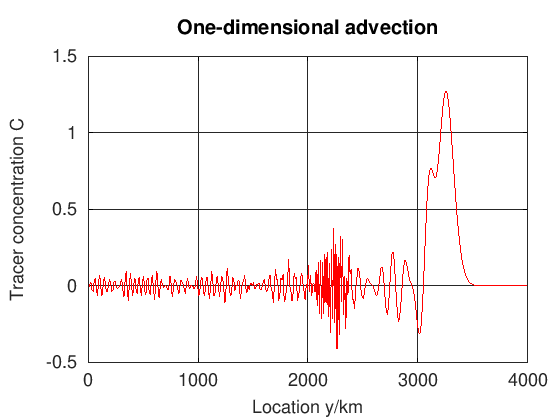

In [25]:
% Run model
run_model_leapfrog(Constants, Sizes, Grids, RunParameters, ModelParameters);

Again your task is to describe your observations, which may be easier if you call the M-file function `run_model_leapfrog` from the M-file script `advect_1d.m` in GNU Octave or MATLAB and watch the animation (for the M-file script, see [advection_1d_upwind](advection_1d_upwind.ipynb)). Finally, discuss the advantages and disadvantages of the “upstream” and “centered-in-space” finite-difference schemes, respectively.